# QoS Prediction Challenge

## 0. Préalable

### Importation des modules

In [1]:
# numerical calculation
import numpy as np
# dataframe
import pandas as pd
# vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
# models
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
# splitting
from sklearn.model_selection import train_test_split
# encoding
from sklearn.preprocessing import OrdinalEncoder
# metrics
from sklearn.metrics import mean_squared_error
# utils
import random
from datetime import datetime as dt
# saving model
import joblib

In [2]:
# Set seed for reproducability
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

### Chargement du jeu de données

In [3]:
DATA_PATH = 'data/' # repertoire des données
train = pd.read_csv(DATA_PATH + 'Train.csv') # ensemble d'apprentissage
test = pd.read_csv(DATA_PATH + 'Test.csv') # ensemble de test
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv') # exemple de soumission
variable_definitions = pd.read_csv(DATA_PATH + 'VariableDefinitions.csv') # definition des variables

In [4]:
train.head(3)

,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
0,Id_qt2qn56050,1624367008,pc1,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,...,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,Residential,51500000.0
1,Id_f1zf07cwb6,1624372465,pc3,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,Residential,50300000.0
2,Id_uoxdz7di5b,1624371871,pc3,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,...,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,Residential,16500000.0


In [28]:
test.head(3)

,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,apparentTemperature,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area
0,Id_ln0e0hfrgx,1624374179,pc2,-97.121875,-12.923750,-87.554375,13.293,39276.0,24.0,20,...,23.05,14.55,0.59,1013.6,2.27,0.83,3.0,16.093,3.07702,Avenue
1,Id_svf7nz9fxv,1624366264,pc4,-65.202500,-9.944375,-35.501875,21.823,39566.0,25.0,20,...,21.56,13.92,0.62,1013.6,2.42,0.95,4.0,16.093,0.66000,Park
2,Id_ww2mh07gwj,1624375795,pc2,-79.298125,-17.468750,-74.823750,24.114,41900.0,27.0,20,...,22.93,14.65,0.60,1013.5,2.26,0.85,3.0,16.093,2.49330,Park


Variables identifiant et objectif

La target de notre dataset est la variable **target**.

In [5]:
ID = 'id'
TARGET = 'target'

## 1. Analyse exploratoire

### 1.1. Analyse de la forme

Dimension du dataset

In [6]:
# Let’s observe the shape of our datasets.
print('Dimension du train set :', train.shape)
print('Dimension du test set :', test.shape)

Dimension du train set : (34274, 41)
Dimension du test set : (18243, 40)


Ratio entre train et test sets

In [7]:
test.shape[0] / train.shape[0] * 100

53.2269358697555

Types des variables

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34274 entries, 0 to 34273
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            34274 non-null  object 
 1   timestamp                     34274 non-null  int64  
 2   device                        34274 non-null  object 
 3   PCell_RSRP_max                34274 non-null  float64
 4   PCell_RSRQ_max                34274 non-null  float64
 5   PCell_RSSI_max                34274 non-null  float64
 6   PCell_SNR_max                 34274 non-null  float64
 7   PCell_Downlink_Num_RBs        34274 non-null  float64
 8   PCell_Downlink_Average_MCS    34274 non-null  float64
 9   PCell_Downlink_bandwidth_MHz  33207 non-null  float64
 10  PCell_Cell_Identity           33207 non-null  float64
 11  PCell_freq_MHz                34274 non-null  float64
 12  SCell_RSRP_max                19012 non-null  float64
 13  S

Analyse des variables qualitatives

In [9]:
train.select_dtypes(include='object').describe()

,id,device,area
count,34274,34274,34274
unique,34274,2,5
top,Id_qt2qn56050,pc1,Park
freq,1,19505,13438


In [10]:
for colonne in list(train.columns):
    print(colonne)
    print(train[colonne].value_counts(), '\n')

id
Id_qt2qn56050    1
Id_ojvi2rdfpw    1
Id_edb0fu4jap    1
Id_9ftaq07qu0    1
Id_65drpv9yul    1
                ..
Id_ge28z7rjds    1
Id_29npmuawod    1
Id_cgkdhn72cf    1
Id_ykdq0weq3r    1
Id_6ovc5xvg0o    1
Name: id, Length: 34274, dtype: int64 

timestamp
1624552037    2
1624548733    2
1624552672    2
1624348630    2
1624552476    2
             ..
1624356799    1
1624545345    1
1624348818    1
1624373680    1
1624376571    1
Name: timestamp, Length: 27373, dtype: int64 

device
pc1    19505
pc3    14769
Name: device, dtype: int64 

PCell_RSRP_max
-85.495000    7
-86.025000    7
-94.078125    6
-88.596875    6
-85.829375    5
             ..
-95.941250    1
-78.746875    1
-92.836875    1
-84.349375    1
-97.323125    1
Name: PCell_RSRP_max, Length: 27457, dtype: int64 

PCell_RSRQ_max
-12.220625    17
-12.361250    15
-12.253125    14
-12.194375    13
-12.323750    13
              ..
-17.967500     1
-18.084478     1
-12.055707     1
-18.013125     1
-17.122500     1
Name: PC

In [11]:
for colonne in list(test.columns):
    print(colonne)
    print(test[colonne].value_counts(), '\n')

id
Id_ln0e0hfrgx    1
Id_9jsf9s9wsf    1
Id_e4m1soef49    1
Id_fkjjdyvn30    1
Id_1cgwmj2yyf    1
                ..
Id_jwrtpqx3pq    1
Id_s98mtaqycr    1
Id_8vtkaopvmq    1
Id_5oxn0xvlj4    1
Id_e2duej4gcq    1
Name: id, Length: 18243, dtype: int64 

timestamp
1624348977    2
1624348342    2
1624348345    2
1624349366    2
1624348232    2
             ..
1624356197    1
1624372450    1
1624374512    1
1624357087    1
1624369388    1
Name: timestamp, Length: 16455, dtype: int64 

device
pc4    9473
pc2    8770
Name: device, dtype: int64 

PCell_RSRP_max
-88.421250     6
-88.391250     5
-95.380625     5
-95.298750     4
-88.218750     4
              ..
-106.062500    1
-73.106250     1
-96.173750     1
-105.715000    1
-103.098125    1
Name: PCell_RSRP_max, Length: 15852, dtype: int64 

PCell_RSRQ_max
-12.723125    9
-12.738750    9
-12.795625    9
-12.310000    9
-12.815625    9
             ..
-15.130625    1
-13.857500    1
-13.546250    1
-13.693125    1
-15.954375    1
Name: PCel

Analyse des variables quantitatives

In [12]:
train.select_dtypes(include='number').describe()

,timestamp,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz,...,apparentTemperature,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,target
count,3.427400e+04,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,33207.000000,3.320700e+04,34274.000000,...,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,3.427400e+04,33946.000000,3.427400e+04
mean,1.624447e+09,-87.085767,-13.061258,-54.435712,11.861843,64089.078835,19.973858,19.233746,1.898801e+07,1926.737469,...,20.076148,13.952753,0.682186,1015.186410,2.613565,0.938075,2.564072,1.609300e+01,3.328803,5.550386e+07
std,9.176344e+04,11.719533,2.463729,10.765029,7.414607,22991.689616,5.054947,1.898843,1.381858e+07,264.412295,...,1.951120,0.462473,0.063657,2.377349,0.756239,0.078149,1.023344,3.552766e-15,2.202747,4.319385e+07
min,1.624348e+09,-175.605625,-24.774375,-87.852500,-15.603000,4.000000,0.000000,5.000000,2.567188e+06,900.000000,...,18.130000,13.300000,0.550000,1011.900000,1.960000,0.760000,1.000000,1.609300e+01,0.000000,4.800000e+04
25%,1.624367e+09,-95.201562,-14.790000,-61.961719,6.431250,43724.000000,17.000000,20.000000,3.282957e+06,1800.000000,...,18.670000,13.610000,0.620000,1013.500000,2.160000,0.940000,2.000000,1.609300e+01,2.171180,2.400000e+07
50%,1.624377e+09,-86.845313,-12.681875,-53.992500,12.171000,62785.000000,21.000000,20.000000,2.635878e+07,1800.000000,...,18.880000,13.800000,0.710000,1013.800000,2.290000,0.970000,3.000000,1.609300e+01,3.009460,4.240000e+07
75%,1.624548e+09,-79.246719,-11.378252,-46.845156,17.579000,87828.000000,24.000000,20.000000,2.694707e+07,2000.000000,...,21.610000,14.110000,0.730000,1017.700000,2.430000,0.990000,3.000000,1.609300e+01,3.454510,7.200000e+07
max,1.624554e+09,-55.550625,-5.389375,-13.032500,28.622000,100471.000000,28.000000,20.000000,5.184258e+07,2600.000000,...,23.880000,14.920000,0.770000,1018.000000,4.250000,1.000000,4.000000,1.609300e+01,9.602590,2.710000e+08


Analyse des données manquantes

In [13]:
train.isnull().sum().sort_values(ascending=False) / train.shape[0] * 100

SCell_Cell_Identity             60.830367
SCell_Downlink_bandwidth_MHz    60.830367
SCell_Downlink_Average_MCS      46.504639
SCell_Downlink_Num_RBs          46.504639
SCell_freq_MHz                  44.529381
SCell_RSRP_max                  44.529381
SCell_SNR_max                   44.529381
SCell_RSSI_max                  44.529381
SCell_RSRQ_max                  44.529381
PCell_Downlink_bandwidth_MHz     3.113147
PCell_Cell_Identity              3.113147
Traffic Jam Factor               0.956994
Altitude                         0.020424
precipProbability                0.000000
temperature                      0.000000
apparentTemperature              0.000000
dewPoint                         0.000000
area                             0.000000
visibility                       0.000000
uvIndex                          0.000000
cloudCover                       0.000000
windSpeed                        0.000000
COG                              0.000000
pressure                         0

In [61]:
test.isnull().sum().sort_values(ascending=False) / test.shape[0] * 100

SCell_Cell_Identity             73.359645
SCell_Downlink_bandwidth_MHz    73.359645
SCell_Downlink_Average_MCS      51.252535
SCell_Downlink_Num_RBs          51.252535
SCell_freq_MHz                  47.223593
SCell_RSRQ_max                  47.223593
SCell_SNR_max                   47.223593
SCell_RSSI_max                  47.223593
SCell_RSRP_max                  47.223593
Traffic Jam Factor               0.685194
Altitude                         0.027408
PCell_Downlink_Average_MCS       0.005482
PCell_Downlink_Num_RBs           0.005482
pressure                         0.000000
humidity                         0.000000
dewPoint                         0.000000
COG                              0.000000
windSpeed                        0.000000
cloudCover                       0.000000
uvIndex                          0.000000
visibility                       0.000000
apparentTemperature              0.000000
temperature                      0.000000
precipProbability                0

### 1.2. Analyse du fond

In [17]:
def timestamp_to_datetime(timestamp) -> dt:
    ''' convertit un entier timestamp de secondes en Datetime
    '''
    return dt.fromtimestamp(timestamp)

In [34]:
train1 = train.copy()
test1 = test.copy()
train1['timestamp'] = train1['timestamp'].apply(timestamp_to_datetime)
test1['timestamp'] = test1['timestamp'].apply(timestamp_to_datetime)
train1.set_index('timestamp', inplace=True)
test1.set_index('timestamp', inplace=True)
display(train1.head(3), test1.head(3))

,id,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-22 13:03:28,Id_qt2qn56050,pc1,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,26368258.0,...,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,Residential,51500000.0
2021-06-22 14:34:25,Id_f1zf07cwb6,pc3,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,2568970.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,Residential,50300000.0
2021-06-22 14:24:31,Id_uoxdz7di5b,pc3,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,2824458.0,...,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,Residential,16500000.0


,id,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,...,apparentTemperature,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-22 15:02:59,Id_ln0e0hfrgx,pc2,-97.121875,-12.923750,-87.554375,13.293,39276.0,24.0,20,3499534.0,...,23.05,14.55,0.59,1013.6,2.27,0.83,3.0,16.093,3.07702,Avenue
2021-06-22 12:51:04,Id_svf7nz9fxv,pc4,-65.202500,-9.944375,-35.501875,21.823,39566.0,25.0,20,26358784.0,...,21.56,13.92,0.62,1013.6,2.42,0.95,4.0,16.093,0.66000,Park
2021-06-22 15:29:55,Id_ww2mh07gwj,pc2,-79.298125,-17.468750,-74.823750,24.114,41900.0,27.0,20,2843400.0,...,22.93,14.65,0.60,1013.5,2.26,0.85,3.0,16.093,2.49330,Park


Analyse et visualisation de la target

<Axes: xlabel='timestamp'>

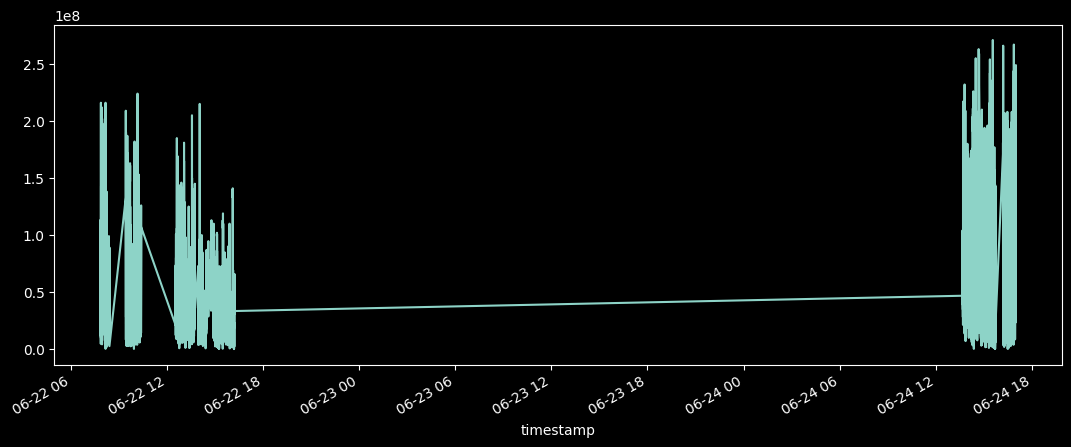

In [38]:
plt.figure(figsize=(13,5))
train1['target'].plot()

Analyse des outliers

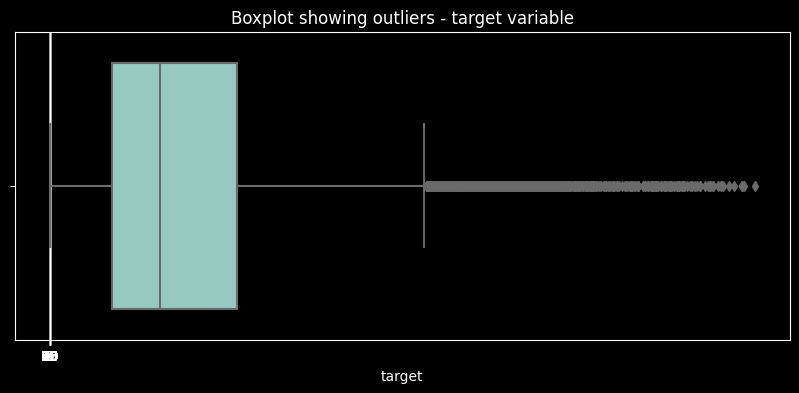

In [26]:
# Check for outliers in the target variable
plt.figure(figsize=(10, 4))
plt.grid()
plt.xticks(np.arange(0, 100, 5))
sns.boxplot(x=train['target'])
plt.title('Boxplot showing outliers - target variable')
plt.show()

#### Compréhension des diffiérentes variables

In [27]:
variable_definitions # schema de definition des variables

,VARIABLENAME,VARIABLE DESCRIPTION
0,id,Unique ID for each row
1,timestamp,Unix timestamp in seconds
2,device,ID of the vehicle carrying the UE
3,PCell_RSRP_max,Maximum reference signal received power in dBm...
4,PCell_RSRQ_max,Maximum reference signal received quality in d...
5,PCell_RSSI_max,Maximum received signal strength indicator in ...
6,PCell_SNR_max,Maximum signal to noise ratio in dB from the p...
7,PCell_Downlink_Num_RBs,Aggregated number of received resource blocks ...
8,PCell_Downlink_TB_Size,Aggregated transport block size in downlink fr...
9,PCell_Downlink_Average_MCS,Average modulation and coding scheme weighted ...


## 2. Preprocessing

Data preprocessing function

In [63]:
def preprocessing_data(data: pd.DataFrame) -> pd.DataFrame:
    ''' Réalise la phase de pré-traitement d'un dataset à savoir l'encodage 
    des variables discrètes et la normalisation de toutes les variables 
    '''
    data2 = data.copy()
    try:
        data1 = data.drop([ID, 'timestamp', TARGET], axis=1)
    except:
        data1 = data.drop([ID, 'timestamp'], axis=1)
    # la liste des colonnes discrètes
    object_columns = list(
        data1.select_dtypes(include='object').columns)
    # encodage des variables discrètes
    encoder = OrdinalEncoder()
    data1[object_columns] = encoder.fit_transform(data1[object_columns])

    data2[data1.columns] = data1
    data2.drop('timestamp', axis=1, inplace=True)
    return data2

In [64]:
train_pp = preprocessing_data(train)
test_pp = preprocessing_data(test)
test_pp.head()

,id,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,...,apparentTemperature,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area
0,Id_ln0e0hfrgx,0.0,-97.121875,-12.923750,-87.554375,13.293,39276.0,24.0,20,3499534.0,...,23.05,14.55,0.59,1013.6,2.27,0.83,3.0,16.093,3.07702,0.0
1,Id_svf7nz9fxv,1.0,-65.202500,-9.944375,-35.501875,21.823,39566.0,25.0,20,26358784.0,...,21.56,13.92,0.62,1013.6,2.42,0.95,4.0,16.093,0.66000,2.0
2,Id_ww2mh07gwj,0.0,-79.298125,-17.468750,-74.823750,24.114,41900.0,27.0,20,2843400.0,...,22.93,14.65,0.60,1013.5,2.26,0.85,3.0,16.093,2.49330,2.0
3,Id_v88r4y03ww,0.0,-110.128125,-13.513750,-92.566875,6.282,76310.0,18.0,20,3499534.0,...,22.95,14.45,0.59,1013.6,2.27,0.82,3.0,16.093,5.74454,1.0
4,Id_2u4y4kzglh,0.0,-117.451250,-18.753125,-93.048125,-5.767,44887.0,7.0,20,3282957.0,...,23.05,14.55,0.59,1013.6,2.27,0.83,3.0,16.093,3.48651,0.0


In [65]:
train_pp.head()

,id,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
0,Id_qt2qn56050,0.0,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,26368258.0,...,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,3.0,51500000.0
1,Id_f1zf07cwb6,1.0,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,2568970.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,3.0,50300000.0
2,Id_uoxdz7di5b,1.0,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,2824458.0,...,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,3.0,16500000.0
3,Id_hzn8nj29gu,0.0,-95.598750,-14.696250,-61.660000,10.726,95955.0,17.0,20.0,26367489.0,...,13.43,0.71,1017.9,1.97,0.99,3.0,16.093,8.80702,0.0,46400000.0
4,Id_2kfrccrfiw,0.0,-97.735000,-14.867500,-63.170625,10.889,83062.0,19.0,20.0,26369024.0,...,13.46,0.71,1017.9,1.97,0.99,3.0,16.093,2.21843,2.0,50200000.0


## 3. Modelling

Evaluation function

In [43]:
def rmse(y_test, y_pred) -> float:
	''' returns the root mean squared error of a model
	'''
	return mean_squared_error(y_test, y_pred, squared=False)

Splitting

In [80]:
# Selecting the independent variables and the target variable
X = train_pp.drop([ID, TARGET], axis = 1)
# X = train_pp
y = train_pp[TARGET]
# spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

### Fitting

Catboost model parameters

In [88]:
params = {
    'n_estimators': 3000,
    'learning_rate': 0.1,
    'objective': 'RMSE',
    'rsm': 0.6,
    'random_seed': 2,
    'early_stopping_rounds': 200,
    'use_best_model': True,
}

In [89]:
CB = CatBoostRegressor(**params)
model_cb = CB
model_cb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=300)
y_pred_cb = model_cb.predict(X_test)
print(f'RMSE Score: {rmse(y_test, y_pred_cb)}')

0:	learn: 39866864.4616809	test: 40757011.3647380	best: 40757011.3647380 (0)	total: 13.4ms	remaining: 40.2s
300:	learn: 8595268.3546057	test: 9609363.9052999	best: 9609363.9052999 (300)	total: 1.93s	remaining: 17.3s
600:	learn: 7458432.3078829	test: 9165242.6387176	best: 9164077.4275089 (598)	total: 3.87s	remaining: 15.4s
900:	learn: 6761791.2377416	test: 8974824.9855853	best: 8974824.9855853 (900)	total: 5.83s	remaining: 13.6s
1200:	learn: 6266331.2916953	test: 8877428.7375593	best: 8877390.9908681 (1196)	total: 7.79s	remaining: 11.7s
1500:	learn: 5848233.1330291	test: 8807667.9642727	best: 8807655.8406733 (1493)	total: 9.89s	remaining: 9.87s
1800:	learn: 5498342.8613864	test: 8768003.7259455	best: 8768003.7259455 (1800)	total: 11.9s	remaining: 7.89s
2100:	learn: 5207228.9478204	test: 8743198.0696939	best: 8741733.6533314 (2096)	total: 13.8s	remaining: 5.92s
2400:	learn: 4943899.4861196	test: 8719947.2330363	best: 8719947.2330363 (2400)	total: 16.4s	remaining: 4.08s
2700:	learn: 47104

RMSE Score: 8827461.907147136

RMSE Score: 8709491.172538169

### Compréhension du modèle

<BarContainer object of 38 artists>

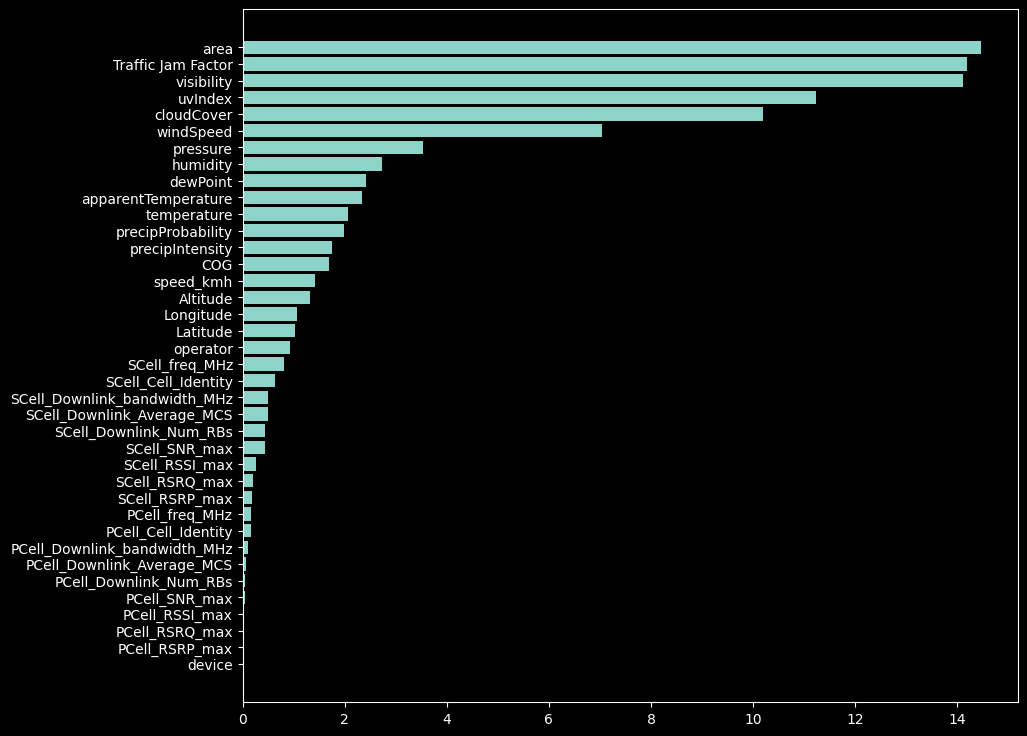

In [90]:
plt.figure(figsize=(10,9))
model = model_cb
plt.barh(X_test.columns.to_list(), pd.Series(model.feature_importances_).sort_values())

Niveaux d'importance des features pris en compte par le modèle

In [91]:
model = model_cb
model.feature_importances_[model.feature_importances_ > 0].size

37

Analyse des prédictions

In [92]:
pred_errors: pd.DataFrame = X_test.copy()
pred_errors[TARGET] = y_test
pred_errors['prediction'] = y_pred_cb
pred_errors['error'] = abs(pred_errors['prediction'] - pred_errors[TARGET])
pred_errors = pred_errors[[TARGET, 'prediction', 'error']]
pred_errors.sort_values(by='error', ascending=False, inplace=True)
pred_errors

,target,prediction,error
2375,44800000.0,1.149491e+08,7.014907e+07
13078,134000000.0,6.969652e+07,6.430348e+07
2000,157000000.0,9.295236e+07,6.404764e+07
13978,78800000.0,1.386987e+08,5.989871e+07
22476,119000000.0,6.008479e+07,5.891521e+07
...,...,...,...
9372,46000000.0,4.599788e+07,2.117944e+03
27995,24000000.0,2.399857e+07,1.432578e+03
17612,49900000.0,4.989884e+07,1.163020e+03
23252,16500000.0,1.649908e+07,9.161491e+02


In [93]:
pred_errors.error.sum()

37868852497.356865

## Submission

In [53]:
sample_submission.head()

,id,target
0,Id_hg4i94kfbg,0.0
1,Id_j1afeth58t,0.0
2,Id_bahkipht8j,0.0
3,Id_t1iry5orn0,0.0
4,Id_dnlh2w774v,0.0


In [94]:
# Make prediction on the test set
test_df = test_pp.drop([ID], axis=1)
predictions = model_cb.predict(test_df)

# Create a submission file
sub_file = pd.DataFrame({ID: test[ID], TARGET: predictions})
sub_file.head()

,id,target
0,Id_ln0e0hfrgx,2.098061e+07
1,Id_svf7nz9fxv,5.767991e+07
2,Id_ww2mh07gwj,8.064313e+07
3,Id_v88r4y03ww,2.023988e+07
4,Id_2u4y4kzglh,3.659230e+06


In [87]:
# Create file
today = dt.now().strftime(format="%Y-%m-%d_%Hh%M")
sub_file.to_csv(f'submissions/submission_{today}.csv', index=False)

## Saving model

In [114]:
# Save the model as a pickle in a file
model = model_cb
filename = 'catboost_public_9903776.468'
joblib.dump(model, f'models/{filename}.pkl')

['models/catboost_public_9903776.468.pkl']